In [5]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!nvidia-smi
!pip install -U git+https://github.com/qubvel/efficientnet

Sat Jun 20 01:07:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%tensorflow_version 2.x

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow.keras.callbacks as cb
import tensorflow.keras.layers as L
import tensorflow.keras as K
import tensorflow as tf

from tqdm.auto import tqdm
from glob import glob
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, zipfile, cv2, shutil

# tf.keras.backend.set_learning_phase(True)

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 100
NUM_CLASSES = 6
train_images_path = '/content/train_images'       # 資料路徑
test_images_path = '/content/test_images'       # 資料路徑

# 資料載入

In [7]:
if not os.path.exists(train_images_path):
    f = zipfile.ZipFile("/content/drive/My Drive/AOI/train_images.zip")
    f.extractall("./")

if not os.path.exists(test_images_path):
    f = zipfile.ZipFile("/content/drive/My Drive/AOI/test_images.zip")
    f.extractall("./")

train_df = pd.read_csv('/content/drive/My Drive/AOI/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/AOI/test.csv')

In [16]:
[os.makedirs(os.path.join(train_images_path, str(i)), exist_ok=True) for i in range(6)]
[os.makedirs(os.path.join(test_images_path, str(i)), exist_ok=True) for i in range(6)]

if len(glob(os.path.join(train_images_path, '*'))) > 10:
    for i, path in enumerate(train_df['ID']):
        src = os.path.join(train_images_path, path)
        dst = os.path.join(train_images_path, str(train_df['Label'][i]), path)
        shutil.move(src, dst)

# 資料增強

In [17]:
# [-1, 1]
def preprocess_fn1(im_array):
    return im_array / 127.5 -1

# [ 0, 1]
def preprocess_fn2(im_array):
    return im_array / 255

# 平均 / 標準差
def preprocess_fn3(im_array):
    return (im_array - np.mean(im_array))/ np.std(im_array)


trn_dagen = ImageDataGenerator(preprocessing_function= preprocess_fn1,
                               rotation_range=40,
                               horizontal_flip=True,
                               vertical_flip=True,
                            #    width_shift_range=0.1, 
                            #    height_shift_range=0.1, 
                            #    shear_range=0.1, 
                            #    zoom_range=0.1, 
                               validation_split=0.1)

trn_gen = trn_dagen.flow_from_directory(train_images_path,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        subset='training',
                                        shuffle=True)

val_gen = trn_dagen.flow_from_directory(train_images_path,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        subset='validation',
                                        shuffle=True)

Found 2277 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


# Callback 設置、模型建立、模型編譯、模型訓練

In [18]:
# 衰退學習率 (Learning rate)
rl_callback = cb.ReduceLROnPlateau(monitor   = "val_loss", 
                                   factor    = 0.5,
                                   patience  = 3, 
                                   verbose   = 0, 
                                   min_delta = 1e-4, 
                                   min_lr    = 1e-6)

es_callback = cb.EarlyStopping(patience=10, 
                               restore_best_weights=True)
callbacks = [
             rl_callback, 
             es_callback
             ]

STEP_SIZE_TRAIN = trn_gen.n // NUM_EPOCHS
STEP_SIZE_VALID = val_gen.n // NUM_EPOCHS

net = efn.EfficientNetB5(input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3),
                         weights= 'noisy-student',
                         include_top= False)

for layer in net.layers: layer.trainable = True

x = net.output
x = L.GlobalAveragePooling2D()(x)
out = L.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=net.input, outputs=out)

model.compile(loss=K.losses.CategoricalCrossentropy(), 
              optimizer=K.optimizers.Adam(), 
              metrics=[K.metrics.CategoricalAccuracy()])

history = model.fit(trn_gen,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs= NUM_EPOCHS,
                    verbose= 2, 
                    validation_data= val_gen,
                    validation_steps= STEP_SIZE_VALID,
                    callbacks= callbacks)

Epoch 1/100
22/22 - 19s - loss: 0.7131 - categorical_accuracy: 0.7681 - val_loss: 1.2871 - val_categorical_accuracy: 0.6719 - lr: 0.0010
Epoch 2/100
22/22 - 17s - loss: 0.4071 - categorical_accuracy: 0.8920 - val_loss: 0.5663 - val_categorical_accuracy: 0.8281 - lr: 0.0010
Epoch 3/100
22/22 - 16s - loss: 0.2485 - categorical_accuracy: 0.9318 - val_loss: 2.0064 - val_categorical_accuracy: 0.7031 - lr: 0.0010
Epoch 4/100
22/22 - 16s - loss: 0.2051 - categorical_accuracy: 0.9542 - val_loss: 1.4178 - val_categorical_accuracy: 0.7812 - lr: 0.0010
Epoch 5/100
22/22 - 16s - loss: 0.2142 - categorical_accuracy: 0.9403 - val_loss: 1.3230 - val_categorical_accuracy: 0.7969 - lr: 0.0010
Epoch 6/100
22/22 - 15s - loss: 0.2061 - categorical_accuracy: 0.9468 - val_loss: 3.6331 - val_categorical_accuracy: 0.5781 - lr: 5.0000e-04
Epoch 7/100
22/22 - 16s - loss: 0.1327 - categorical_accuracy: 0.9601 - val_loss: 1.4298 - val_categorical_accuracy: 0.7031 - lr: 5.0000e-04
Epoch 8/100
22/22 - 16s - loss: 0

# 觀察 Accuracy、Loss

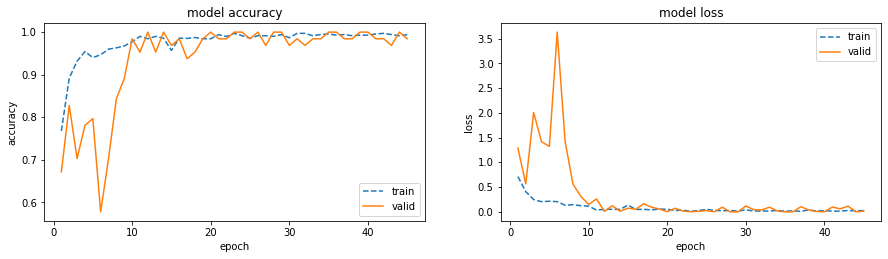

In [21]:
epochs = range(1, len(history.history['categorical_accuracy']) + 1)

plt.figure(1, figsize = (15, 8)) 

plt.subplot(221)
plt.plot(epochs, history.history['categorical_accuracy'], linestyle='--')
plt.plot(epochs, history.history['val_categorical_accuracy'])
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.title('model accuracy')  
plt.legend(['train', 'valid']) 

plt.subplot(222)
plt.plot(epochs, history.history['loss'], linestyle='--')
plt.plot(epochs, history.history['val_loss'], label = 'Validation Loss')
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

# 預測

In [22]:
def predict_2(model, predict_df, image_path, x_col, y_col, batch_size=32, preprocessing_function=None):
    '''
        預測併儲存 csv
    '''
    # init
    model      = model
    predict_df = predict_df
    image_path = image_path
    batch_size = batch_size
    total_len  = len(predict_df[x_col]) // batch_size + 1

    def image_predict(image_id, batch_size=32):
        ''' 流程: 
            single image read
            img to array
            preprocessing
            append
        '''

        batch_img = []
        for imgid in image_id:
            img = load_img(os.path.join(image_path, imgid), target_size= (IMAGE_SIZE, IMAGE_SIZE))
            img = img_to_array(img)
            img = preprocessing_function(img)
            batch_img.append(img)
        
        batch_img = np.array(batch_img)
        pre = np.argmax(model.predict(batch_img), axis=1)
        return pre
    
    pic = 0
    for i in tqdm(range(total_len)):
        # image predict
        pre_list = image_predict(predict_df[x_col][pic: pic + batch_size])
        
        # to_csv
        for pre in pre_list:
            if len(predict_df[x_col]) > pic:
                predict_df[y_col][pic] = pre
                pic += 1

# 預測並寫入 csv
predict_2(model,
          test_df,
          test_images_path,
          x_col='ID',
          y_col='Label',
          batch_size=32,
          preprocessing_function= preprocess_fn1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 儲存 csv

In [23]:
test_df.to_csv('./test.csv')